# Document-level distances

## Load the text and brain activation data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import binarize
from collections import OrderedDict

In [2]:
atlas_labels = pd.read_csv("../data/atlases/harvard-oxford.csv")
act_bin = pd.read_csv("../data/dcm_0mm_thres0.csv", index_col=0) # Previously binarized
act_bin = act_bin[atlas_labels["PREPROCESSED"]]
act_bin.mean().mean()

0.2984103746007817

In [3]:
def mean_thres(df):
    col_mean = df.mean()
    df_bin = np.empty((df.shape[0], df.shape[1]))
    i = 0
    for col, doc_mean in col_mean.iteritems():
        df_bin[:,i] = 1 * (df[col] > doc_mean)
        i += 1
    df_bin = pd.DataFrame(df_bin, columns=df.columns, index=df.index)
    return df_bin

In [4]:
dtm = pd.read_csv("../data/dtm_190325.csv.gz", compression="gzip", index_col=0)
dtm_bin = mean_thres(dtm)
dtm_bin.mean().mean()

0.018405182706581442

In [5]:
pmids = dtm_bin.index.intersection(act_bin.index)
len(pmids)

18155

## Load the brain systems

In [6]:
dom_lists = pd.read_csv("../lists/lists/lists_dsm_class_opsim.csv", index_col=None)

In [7]:
words = sorted(list(set(dom_lists["TOKEN"])))
structures = sorted(list(act_bin.columns))
domains = list(OrderedDict.fromkeys(dom_lists["CLASS"]))

In [8]:
dom_circuits = pd.read_csv("../lists/circuits/circuits_domain_dsm.csv", index_col=0)

In [9]:
dom_systems = pd.DataFrame(0.0, index=words+structures, columns=domains)
for dom in domains:
    for word in dom_lists.loc[dom_lists["CLASS"] == dom, "TOKEN"]:
        dom_systems.loc[word, dom] = 1.0
    for struct in structures:
        dom_systems.loc[struct, dom] = dom_circuits.loc[struct, dom]
dom_systems[dom_systems > 0.0] = 1.0
dom_systems.shape

(207, 8)

## Assign documents to systems

In [10]:
from scipy.spatial.distance import cdist

In [11]:
dtm_words = dtm_bin.loc[pmids, words]
act_structs = act_bin.loc[pmids, structures]

In [12]:
docs = dtm_words.copy()
docs[structures] = act_structs.copy()
docs.shape

(18155, 207)

In [13]:
dom_dists = cdist(docs.values, dom_systems.values.T, metric="dice")
dom_dists.shape

(18155, 8)

In [14]:
doc2dom = {pmid: 0 for pmid in pmids}
for i, pmid in enumerate(pmids):
    doc2dom[pmid] = np.argmin(dom_dists[i,:]) + 1

In [15]:
doc2dom_df = pd.Series(doc2dom)
doc2dom_df.to_csv("data/doc2dom_dsm_class.csv", header=False)

In [16]:
doc2dom_df = pd.read_csv("data/doc2dom_dsm_class.csv", header=None, index_col=0)
doc2dom = {int(pmid): int(dom) for pmid, dom in doc2dom_df.iterrows()}

## Plot document distances

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm, font_manager, rcParams
import warnings
warnings.simplefilter("ignore", UserWarning)
% matplotlib inline

In [18]:
arial = "../style/Arial Unicode.ttf"
rcParams["axes.linewidth"] = 1

In [19]:
dists = cdist(docs, docs, metric="dice")
dists = pd.DataFrame(dists, index=pmids, columns=pmids)

In [19]:
ordered_doms = range(1, len(domains)+1)

In [21]:
dom_pmids = []
for dom in ordered_doms:
    dom_pmids += [pmid for pmid, sys in doc2dom.items() if sys == dom]

In [22]:
dists = dists[dom_pmids].loc[dom_pmids]

In [23]:
transitions = []
for i, pmid in enumerate(dom_pmids):
    if doc2dom[dom_pmids[i-1]] != doc2dom[pmid]:
        transitions.append(i)

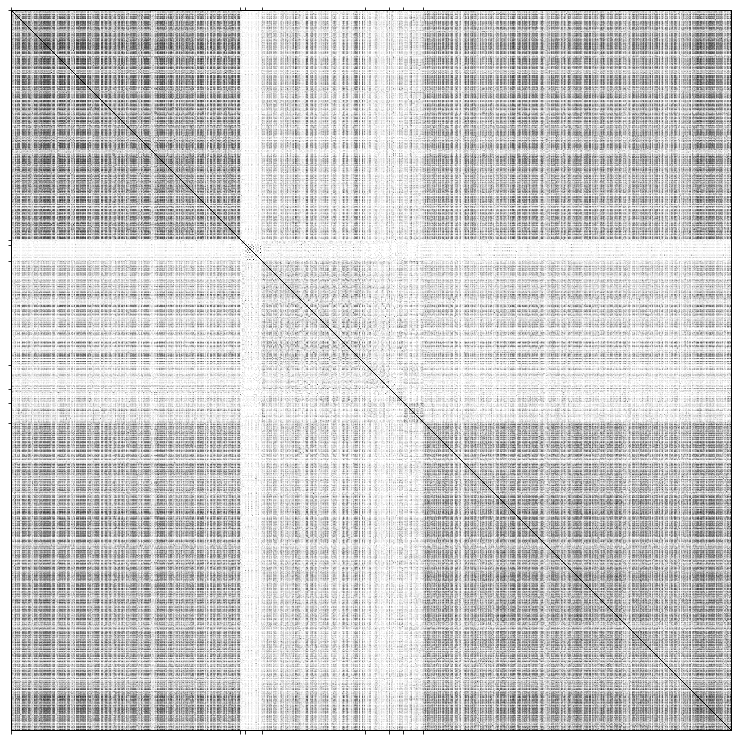

In [24]:
fig = plt.figure(figsize=(10,10), frameon=False)
ax = fig.add_axes([0,0,1,1])

X = dists.values.astype(np.float)
im = ax.matshow(X, cmap=cm.Greys_r, vmin=0, vmax=1, alpha=1) 
plt.xticks(transitions)
plt.yticks(transitions)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()
plt.savefig("figures/dist_dsm_class.png", dpi=250, bbox_inches="tight")
plt.show()

## Compute distance ratios

In [20]:
dom2docs = {dom: [] for dom in domains}
for doc, dom in doc2dom.iteritems():
    dom2docs[domains[dom-1]].append(doc)

In [21]:
for dom in domains:
    print("{:22s} {}".format(dom, len(dom2docs[dom])))

DEVELOPMENTAL          5790
PSYCHOTIC              117
BIPOLAR                422
DEPRESSIVE             2609
ANXIETY                605
OBSESSIVE_COMPULSIVE   355
TRAUMA_STRESSOR        505
COGNITIVE              7752


In [22]:
centroid = np.mean(docs).values
dist_ints, dist_exts, dist_rats = [], [], []
for dom in domains:
    dom_pmids = dom2docs[dom]
    dom_vecs = docs.loc[dom_pmids].values
    dom_centroid = np.mean(dom_vecs, axis=0)
    n_docs = dom_vecs.shape[0]
    dist_int = np.sum((dom_vecs - dom_centroid) ** 2)
    dist_ext = np.sum((dom_vecs - centroid) ** 2)
    ratio = dist_ext / dist_int
    dist_ints.append(dist_int)
    dist_exts.append(dist_ext)
    dist_rats.append(ratio)
    print("{:30s}\t{:10.3f} / {:10.3f} = {:4.3f}".format(
          dom, dist_int, dist_ext, ratio))
print("")
print("TOTAL\t\t\t{:10.3f} / {:10.3f} = {:4.3f}".format(
      np.mean(dist_ints), np.mean(dist_exts), np.mean(dist_exts) / np.mean(dist_ints)))

DEVELOPMENTAL                 	151104.775 / 163495.637 = 1.082
PSYCHOTIC                     	  1137.128 /   2178.971 = 1.916
BIPOLAR                       	  2474.972 /   6466.071 = 2.613
DEPRESSIVE                    	 61194.322 /  68522.940 = 1.120
ANXIETY                       	 10075.071 /  13474.699 = 1.337
OBSESSIVE_COMPULSIVE          	  3800.806 /   6515.918 = 1.714
TRAUMA_STRESSOR               	  8214.186 /  11491.186 = 1.399
COGNITIVE                     	161817.530 / 166369.874 = 1.028

TOTAL			 49977.349 /  54814.412 = 1.097


In [23]:
df = pd.DataFrame({"OBSERVED": dist_rats}, index=domains)
df.head(8)

,OBSERVED
DEVELOPMENTAL,1.082002
PSYCHOTIC,1.916205
BIPOLAR,2.612584
DEPRESSIVE,1.119760
ANXIETY,1.337430
OBSESSIVE_COMPULSIVE,1.714352
TRAUMA_STRESSOR,1.398944
COGNITIVE,1.028133


### Bootstrap distributions

In [24]:
n_iter = 10000

In [57]:
df_boot = np.empty((len(domains), n_iter))
for n in range(n_iter):
    boot = np.random.choice(docs.columns, size=len(docs.columns), replace=True)
    centroid = np.mean(docs[boot]).values
    for i, dom in enumerate(domains):
        dom_pmids = dom2docs[dom]
        dom_vecs = docs.loc[dom_pmids, boot].values
        dom_centroid = np.mean(dom_vecs, axis=0).reshape(1,dom_vecs.shape[1])
        n_docs = dom_vecs.shape[0]
        dist_int = np.sum((dom_vecs - dom_centroid) ** 2)
        dist_ext = np.sum((dom_vecs - centroid) ** 2)
        df_boot[i,n] = dist_ext / dist_int
    if n % int(n_iter / 10.0) == 0:
        print("Processed {} iterations".format(n))

Processed 0 iterations
Processed 1000 iterations
Processed 2000 iterations
Processed 3000 iterations
Processed 4000 iterations
Processed 5000 iterations
Processed 6000 iterations
Processed 7000 iterations
Processed 8000 iterations
Processed 9000 iterations


In [58]:
df_boot = pd.DataFrame(df_boot, index=domains, columns=range(n_iter))
df_boot.to_csv("data/mod_boot_dsm_class_{}iter.csv".format(n_iter))

### Null distributions

In [59]:
df_null = np.empty((len(domains), n_iter))
for n in range(n_iter):
    null = np.random.choice(range(docs.shape[1]), size=docs.shape[1], replace=False)
    centroid = np.mean(docs)[null].values
    for i, dom in enumerate(domains):
        dom_pmids = dom2docs[dom]
        dom_vecs = docs.loc[dom_pmids].values
        dom_centroid = np.mean(dom_vecs, axis=0)[null]
        n_docs = dom_vecs.shape[0]
        dist_int = np.sum((dom_vecs - dom_centroid) ** 2)
        dist_ext = np.sum((dom_vecs - centroid) ** 2)
        df_null[i,n] = dist_ext / dist_int
    if n % int(n_iter / 10.0) == 0:
        print("Processed {} iterations".format(n))

Processed 0 iterations
Processed 1000 iterations
Processed 2000 iterations
Processed 3000 iterations
Processed 4000 iterations
Processed 5000 iterations
Processed 6000 iterations
Processed 7000 iterations
Processed 8000 iterations
Processed 9000 iterations


In [60]:
df_null = pd.DataFrame(df_null, index=domains, columns=range(n_iter))
df_null.to_csv("data/mod_null_dsm_class_{}iter.csv".format(n_iter))

### Comparison tests

In [25]:
from statsmodels.stats import multitest

In [27]:
df_boot = pd.read_csv("data/mod_boot_dsm_class_{}iter.csv".format(n_iter), index_col=0)
df_null = pd.read_csv("data/mod_null_dsm_class_{}iter.csv".format(n_iter), index_col=0)

In [28]:
pval = []
for dom in domains:   
    dom_boot = df_boot.loc[dom].values
    dom_null = df_null.loc[dom].values
    p = np.sum(np.less(dom_boot, np.max(dom_null))) / float(n_iter)
    pval.append(p)
    df.loc[dom, "P"] = p
df["P_COR"] = multitest.multipletests(pval, method="fdr_bh")[1]
for dom in domains:
    for star, alpha in zip(["*", "**", "***"], [0.05, 0.01, 0.001]):
        if df.loc[dom, "P_COR"] < alpha:
            df.loc[dom, "STARS"] = star
df = df.loc[domains, ["OBSERVED", "P", "P_COR", "STARS"]]
df

,OBSERVED,P,P_COR,STARS
DEVELOPMENTAL,1.082002,0.0000,0.000000,***
PSYCHOTIC,1.916205,0.0703,0.112480,NaN
BIPOLAR,2.612584,0.3295,0.329500,NaN
DEPRESSIVE,1.119760,0.1697,0.193943,NaN
ANXIETY,1.337430,0.1385,0.184667,NaN
OBSESSIVE_COMPULSIVE,1.714352,0.0593,0.112480,NaN
TRAUMA_STRESSOR,1.398944,0.0000,0.000000,***
COGNITIVE,1.028133,0.0000,0.000000,***


### Violin plots

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm, font_manager, rcParams
import warnings
warnings.simplefilter("ignore", UserWarning)
% matplotlib inline

In [30]:
arial = "../style/Arial Unicode.ttf"
prop = font_manager.FontProperties(fname=arial, size=20)
prop_lg = font_manager.FontProperties(fname=arial, size=24)
rcParams["axes.linewidth"] = 1.5

In [31]:
palette = ["#7D74A3", # Purple
           "#D1E29E", # Chartreuse
           "#BA7E39", # Orange
           "#778AA3", # Blue
           "#CE7D69", # Red
           "#B07EB6", # Magenta
           "#CEBE6D", # Yellow
           "#77B58A"] # Green

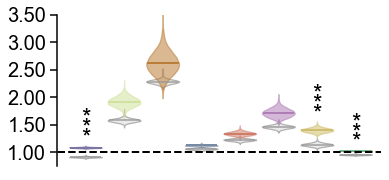

In [42]:
# Set up figure
fig = plt.figure(figsize=(4.5, 2.1))
ax = fig.add_axes([0,0,1,1])

for i, dom in enumerate(domains):
    
    # Null distribution
    data = sorted(df_null.iloc[i])
    obs = np.mean(data)
    plt.plot([i-0.37, i+0.38], [obs, obs], 
             c="#999999", alpha=0.7, lw=2)
    v = ax.violinplot(data, positions=[i], 
                      showmeans=False, showmedians=False, widths=0.85)
    for pc in v["bodies"]:
        pc.set_facecolor("#d8d8d8")
        pc.set_edgecolor("#6d6d6d")
        pc.set_linewidth(1.25)
        pc.set_alpha(0.5)
    for line in ["cmaxes", "cmins", "cbars"]:
        v[line].set_edgecolor("none")

    # Bootstrap distribution
    data = sorted(df_boot.iloc[i])
    obs = df["OBSERVED"][i]
    plt.plot([i-0.38, i+0.39], [obs, obs], 
             c=palette[i], alpha=1, lw=2)
    v = ax.violinplot(data, positions=[i], 
                      showmeans=False, showmedians=False, widths=0.85)
    for pc in v["bodies"]:
        pc.set_facecolor(palette[i])
        pc.set_edgecolor(palette[i])
        pc.set_linewidth(1.25)
        pc.set_alpha(0.55)
    for line in ["cmaxes", "cmins", "cbars"]:
        v[line].set_edgecolor("none")
    
    # Comparison test
    for alpha, dy in [(0.05, 0), (0.01, 0.18), (0.001, 0.36)]:
        if df.loc[dom, "P_COR"] <= alpha:
            plt.text(i-0.125, max(data) + dy, "*", fontproperties=prop_lg)
    
plt.plot([-1,len(ordered_doms)], [1, 1], 
         linestyle="dashed", c="k", alpha=1, linewidth=2)

# Set plot parameters
plt.xticks([])
plt.yticks([1,1.5,2,2.5,3,3.5], 
           ["1.00", "1.50", "2.00", "2.50", "3.00", "3.50"], fontproperties=prop)
plt.xlim([-0.75, len(ordered_doms)-0.35])
plt.ylim([0.75, 3.5])
for side in ["right", "top", "bottom"]:
    ax.spines[side].set_visible(False)
ax.xaxis.set_tick_params(width=1.5, length=0)
ax.yaxis.set_tick_params(width=1.5, length=7)

# Export figure
plt.savefig("figures/dist_ratios_dsm_class_{}iter.png".format(n_iter), 
            dpi=250, bbox_inches="tight")
plt.show()